# Replication of Words are not Wind

> A replication of a paper by Marcus Krellner and The-Anh Han

In [ ]:
#| default_exp repl_word_not_wind

In [16]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import scipy
import seaborn as sns

In [47]:
@multi
def build_payoffs(models: dict):
    return models.get('payoffs_key')

@method(build_payoffs, 'words_not_wind_small_mutation_limit_primitive')
def build_payoffs(models: dict):
    names = ['payoffs_state', 'ca', 'b', 'err_p']
    payoffs_state, ca, b, err_p = [models[k] for k in names]
    strategy_profile = payoffs_state["strategy_profile"]
    assert len(strategy_profile)==2
    A, B = strategy_profile
    join = {"1": "1",
            "2": "1",
            "3": "1",
            "4": "2",
            "5": "2",
            "6": "2",
            "7": "3",
            "8": "3",
            "9": "3",}
    help = {"1": "1",
            "2": "2",
            "3": "3",
            "4": "1",
            "5": "2",
            "6": "3",
            "7": "1",
            "8": "2",
            "9": "3",}
    # r under assumption 2a
    # Assumption 2c would set all values to 0
    # Those who never join receive a reputation of 0, and it doesn't affect their payoffs anyways
    r = {"1": 1 - err_p,
        "2": 1 - err_p,
        "3": err_p, # Under assumption 2b this would be 0
        "4": 1-err_p,
        "5": 1-err_p,
        "6": err_p, # Under assumption 2b this would be 0
        "7": 0,
        "8": 0,
        "9": 0,}
    w_ij = {"1": 1, "2": r[B], "3": 0}[join[A]]
    w_ji = {"1": 1, "2": r[A], "3": 0}[join[B]]
    x_ij = {"1": 1, "2": w_ij*w_ji, "3": 0}[help[A]]
    x_ji = {"1": 1, "2": w_ij*w_ji, "3": 0}[help[B]]
    
    p_A = -ca * w_ij * w_ji - x_ij + b * x_ji
    p_B = -ca * w_ji * w_ij - x_ji + b * x_ij
    
    # We have 9 * 9 = 81 possible outcomes of an interaction between players
    # Even if there is a lot of repetition, this is still an unreasonable
    # amount of work to do. I would be simpler to define the possible 
    # flow payoffs and then work out what people chose.
    
    payoffs = {"P1": p_A , "P2": p_B}
        
    return {**models, "flow_payoffs": payoffs}

@method(build_payoffs, 'words_not_wind_small_mutation_limit')
def build_payoffs(models: dict):
    # strategy_set = models["strategy_set"]
    strategy_set = [f"{i}" for i in range(1, 10)]
    payoffs = {}
    for A in strategy_set:
        for B in strategy_set:
            profile = A + "-" + B
            payoffs_state = {"strategy_profile": [A, B]}
            payoffs_key = "words_not_wind_small_mutation_limit_primitive"
            temp_models = {**models,
                           'payoffs_key': payoffs_key,
                           "payoffs_state": payoffs_state}
            payoffs[profile] = build_payoffs(temp_models)["flow_payoffs"]
    return {**models, "payoffs": payoffs}


In [48]:
Z = {"S1": 50}
β = 1
sector_strategies = {"S1": [1, 2, 3, 4, 5, 6, 7, 8, 9],}
allowed_sectors = {"P2": ["S1"],
                   "P1": ["S1"], }
models_base = {"payoffs_key": "words_not_wind_small_mutation_limit",
               "dispatch-type": 'multiple-populations',
               "sd-method": "quantecon",
               "β": β,
               "Z": Z,
               "allowed_sectors": allowed_sectors,
               "sector_strategies": sector_strategies,
               }

In [62]:
args = {"b": np.arange(0, 10, 0.5),
        "ca": np.arange(0, 2, 0.1),
        "err_p": [0, 0.01, 0.05],
        "β": [1],
        }

models = {**models_base,
          **model_builder(args)}
models['β'] = {"S1": models['β'],}

In [63]:
{k:v.shape for k, v in models.items() if isinstance(v, np.ndarray)}

{'b': (1200,), 'ca': (1200,), 'err_p': (1200,)}

In [64]:
results = thread_macro(models,
                        create_profiles,
                        apply_profile_filters,
                        build_payoffs,
                        build_transition_matrix,
                        find_ergodic_distribution,
                        calculate_sd_helper,
                        )
df = thread_macro(results,
                  results_to_dataframe_egt,)

/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:492: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


In [65]:
df.ca.unique()

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [66]:
df

,b,ca,err_p,1_frequency,2_frequency,3_frequency,4_frequency,5_frequency,6_frequency,7_frequency,8_frequency,9_frequency
0,0.0,0.0,0.00,1.667938e-01,5.976042e-03,7.816798e-02,1.667938e-01,2.145135e-03,7.816798e-02,0.275781,1.130869e-01,1.130869e-01
1,0.0,0.0,0.01,1.650945e-01,5.738415e-03,7.839734e-02,1.691314e-01,2.261574e-03,7.924739e-02,0.274966,1.125819e-01,1.125819e-01
2,0.0,0.0,0.05,1.589717e-01,4.774251e-03,7.915695e-02,1.784132e-01,2.735639e-03,8.367076e-02,0.271451,1.104130e-01,1.104130e-01
3,0.0,0.1,0.00,3.364598e-02,1.311099e-03,1.368650e-02,3.407008e-02,4.128973e-04,1.506474e-01,0.438541,1.638426e-01,1.638426e-01
4,0.0,0.1,0.01,3.335397e-02,1.238718e-03,1.371004e-02,3.585231e-02,4.483223e-04,1.513269e-01,0.437386,1.633418e-01,1.633418e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,9.5,1.8,0.01,1.692347e-19,3.954160e-21,2.420710e-111,4.084270e-19,6.481317e-23,1.526553e-93,1.000000,5.250757e-92,5.250757e-92
1196,9.5,1.8,0.05,1.695198e-19,2.984158e-21,1.231751e-111,1.168788e-17,5.212251e-29,2.733296e-94,1.000000,3.145348e-92,3.145348e-92
1197,9.5,1.9,0.00,1.502587e-20,6.051678e-22,2.308745e-111,1.502587e-20,6.051678e-22,5.239686e-92,1.000000,1.262305e-91,1.262305e-91
1198,9.5,1.9,0.01,1.535908e-20,3.576744e-22,2.198441e-112,3.886764e-20,6.114482e-24,1.506935e-93,1.000000,5.201434e-92,5.201434e-92


KeyError: 'threshold_society_prefers_safety'

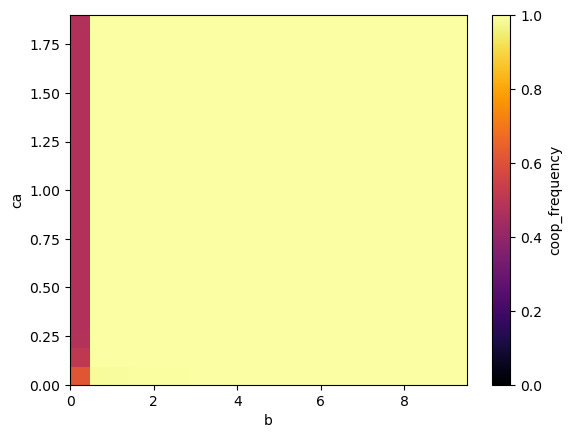

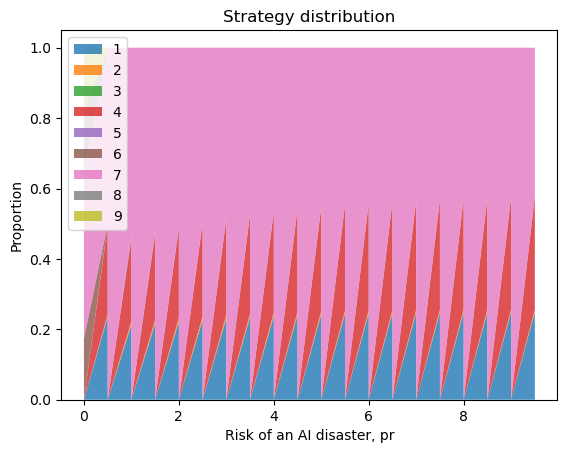

In [70]:
df['coop_frequency'] = df["1_frequency"] + df["2_frequency"] + df["4_frequency"] + df["7_frequency"]
df_filtered = df[(df["err_p"]==0.01)]
table = df_filtered.pivot_table(index='ca', columns='b', values='coop_frequency')
plot_heatmap(table, xlabel="b", ylabel="ca", zlabel="coop_frequency")

plot_strategy_distribution(df_filtered, strategy_set=[f"{i}" for i in range(1,10)], x="b")